# Mean-field theory of asymmetric Ising models with binary spins (in JAX)

In [5]:
from functools import partial

import jax
import jax.numpy as jnp

from jaxopt import AndersonAcceleration


def update_naive_mf(m0, _, x, J):
    """See Eq. (22)."""
    print(m0.shape)
    m1 = jnp.tanh(x + jnp.einsum("i j, j -> i", J, m0))
    return m1, m0


def update_tap_mf(m0, _, x, J):
    """See Eq. (26)."""

    def tap(m, _m0, _x, _J):
        return jnp.tanh(
            _x
            + jnp.einsum("i j, j -> i", _J, _m0)
            - m * jnp.einsum("i j, j -> i", _J**2, (1.0 - _m0**2))
        )

    m1 = (
        AndersonAcceleration(fixed_point_fun=tap, tol=1e-3, maxiter=10)
        .run(m0, m0, x, J)
        .params
    )
    return m1, m0


def time_evolution(m0, steps, update_fun):
    final_carry, stacked_outputs = jax.lax.scan(update_fun, init=m0, xs=steps)
    return final_carry, stacked_outputs


def init_params(key, N, beta, X0, J_mu, J_sigma):
    x_key, J_key = jax.random.split(key)
    x = jax.random.uniform(x_key, shape=(N,), minval=-beta * X0, maxval=beta * X0)
    J = beta * J_mu * N**-1 + beta * J_sigma * N**-0.5 * jax.random.normal(
        J_key, shape=(N, N)
    )
    return x, J


def simulate(
    key, m0, steps, beta, X0=0.5, J_mu=1.0, J_sigma=0.1, update_fun=update_tap_mf
):
    x, J = init_params(key, m0.shape[-1], beta, X0, J_mu, J_sigma)
    wrapped_time_evolution = partial(
        time_evolution,
        steps=steps,
        update_fun=partial(update_fun, x=x, J=J),
    )
    final_carry, stacked_outputs = jax.vmap(wrapped_time_evolution)(m0)
    return final_carry, stacked_outputs

In [6]:
import matplotlib.pyplot as plt


beta_c = 1.1108
num_spins = 512
steps = jnp.arange(0, 128)

### Single trajectory from all-ones state, naive

(512,)


<Figure size 640x480 with 0 Axes>

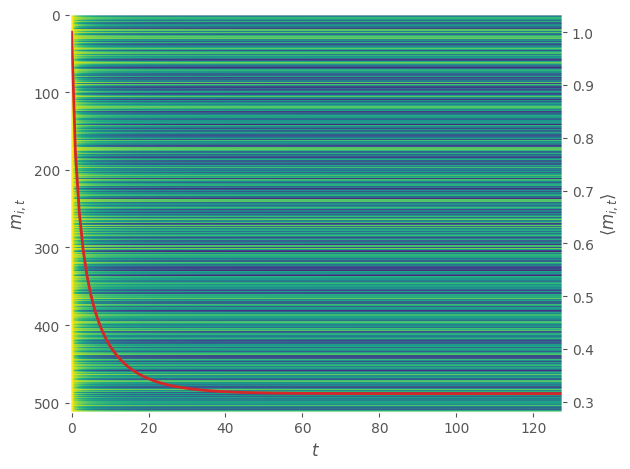

In [11]:
key = jax.random.PRNGKey(2666)
params_key, _ = jax.random.split(key)

m0 = jnp.ones((1, num_spins))
_, stacked_outputs = simulate(params_key, m0, steps, beta_c, update_fun=update_naive_mf)

y = stacked_outputs[0, :, :]

with plt.style.context("ggplot"):
    plt.clf()
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$m_{i,t}$")
    ax1.imshow(y.transpose((1, 0)), aspect="auto")
    ax1.grid(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"$\langle m_{i,t} \rangle$")
    ax2.plot(steps, y.mean(axis=-1), color="tab:red", linewidth=2.0)
    ax2.grid(False)

    fig.tight_layout()
    plt.show()

### Single trajectory from all-ones state, naive vs TAP

(512,)


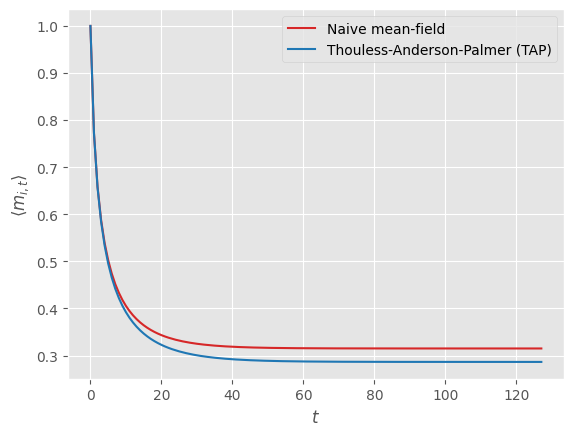

In [12]:
key = jax.random.PRNGKey(2666)
params_key, m0_key = jax.random.split(key)

m0 = jnp.ones((1, num_spins))
_, stacked_outputs_naive = simulate(
    params_key, m0, steps, beta_c, update_fun=update_naive_mf
)
_, stacked_outputs_tap = simulate(params_key, m0, steps, beta_c)

y_naive = stacked_outputs_naive.mean(axis=-1).transpose((1, 0))
y_tap = stacked_outputs_tap.mean(axis=-1).transpose((1, 0))

with plt.style.context("ggplot"):
    plt.plot(steps, y_naive, label="Naive mean-field", color="tab:red", linewidth=1.5)
    plt.plot(
        steps,
        y_tap,
        label="Thouless-Anderson-Palmer (TAP)",
        color="tab:blue",
        linewidth=1.5,
    )
    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\langle m_{i,t} \rangle$")
    plt.show()

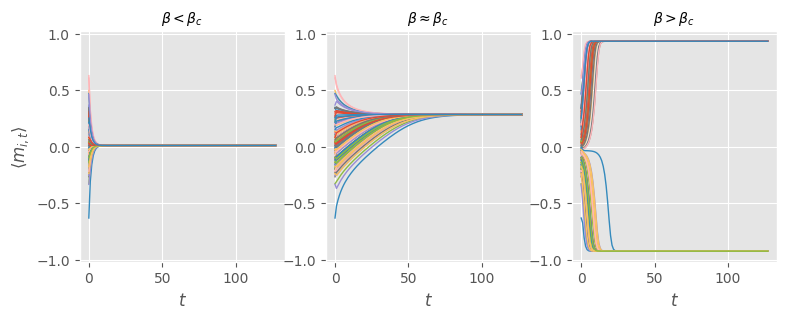

In [13]:
key = jax.random.PRNGKey(2666)
params_key, m0_key = jax.random.split(key)

m0 = 5 * jax.random.normal(m0_key, shape=(100, num_spins))
_, stacked_outputs_below = simulate(params_key, m0, steps, 0.5 * beta_c)
_, stacked_outputs_near = simulate(params_key, m0, steps, beta_c)
_, stacked_outputs_above = simulate(params_key, m0, steps, 2 * beta_c)

with plt.style.context("ggplot"):
    plt.figure(figsize=(9, 3))

    ax1 = plt.subplot(131)
    plt.plot(
        steps, stacked_outputs_below.mean(axis=-1).transpose((1, 0)), linewidth=1.0
    )
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\langle m_{i,t} \rangle$")
    plt.title(r"$\beta < \beta_c$", fontsize=10)

    ax2 = plt.subplot(132, sharey=ax1)
    plt.plot(steps, stacked_outputs_near.mean(axis=-1).transpose((1, 0)), linewidth=1.0)
    plt.xlabel(r"$t$")
    plt.title(r"$\beta \approx \beta_c$", fontsize=10)

    ax3 = plt.subplot(133, sharey=ax1)
    plt.plot(
        steps, stacked_outputs_above.mean(axis=-1).transpose((1, 0)), linewidth=1.0
    )
    plt.xlabel(r"$t$")
    plt.title(r"$\beta > \beta_c$", fontsize=10)

    plt.show()

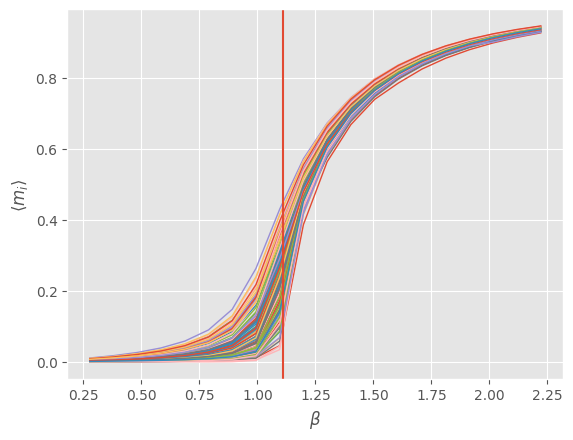

In [14]:
key = jax.random.PRNGKey(2666)
params_key, m0_key = jax.random.split(key)

m0 = jax.random.normal(m0_key, shape=(1, num_spins))
_, stacked_outputs = jax.vmap(
    jax.vmap(simulate, in_axes=(0, None, None, None)), in_axes=(None, None, None, 0)
)(
    jax.random.split(params_key, num=100),
    m0,
    steps,
    jnp.linspace(0.25 * beta_c, 2 * beta_c, num=20),
)

y = jnp.abs(stacked_outputs[:, :, 0, -1, :].mean(axis=-1))

with plt.style.context("ggplot"):
    plt.plot(jnp.linspace(0.25 * beta_c, 2 * beta_c, num=20), y, linewidth=1.0)
    plt.axvline(x=beta_c)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$\langle m_{i} \rangle$")
    plt.show()